## Гомография

```
1) сделать панораму из более чем 2х изображений
2) реализовать метод автоматического триангулирования и применить для своих фото.
```

In [1]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
from scipy import ndimage
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from numpy import *
from matplotlib.pyplot import *
from scipy import ndimage
from pylab import *
from numpy import *
import scipy
import scipy.spatial
from collections.abc import Mapping

### 1. Панорама из >2х изображений

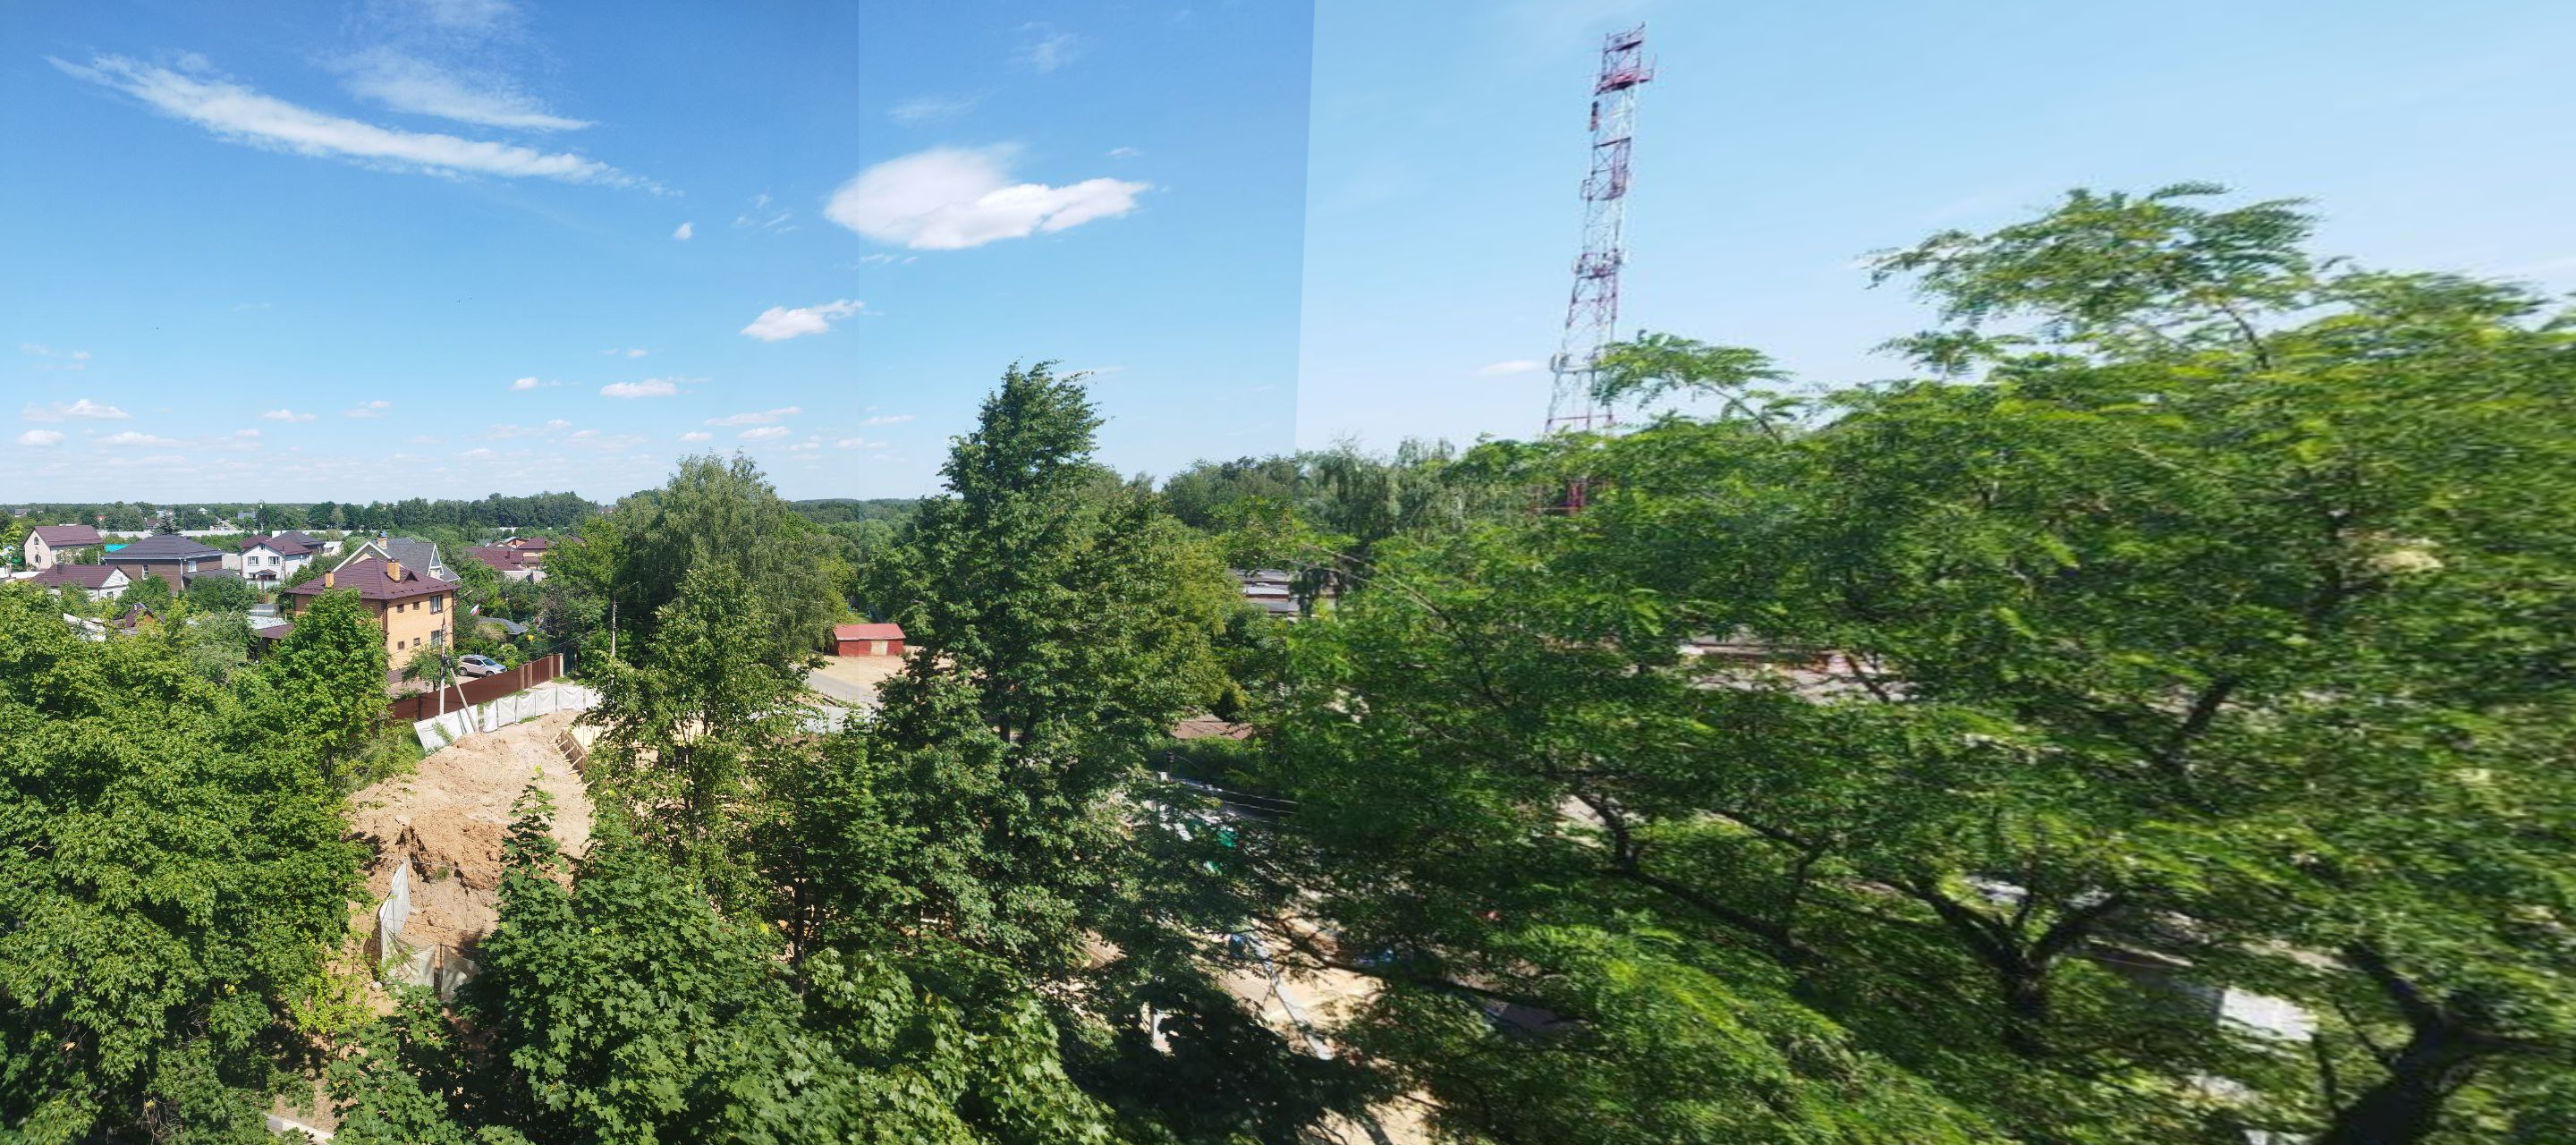

In [76]:
# Загрузка изображений
img1 = cv2.imread('data/img1.jpg')
img2 = cv2.imread('data/img2.jpg')
img3 = cv2.imread('data/img3.jpg')
imgs = [img3, img2, img1]

def homography_matrix(img1, img2):
    # Преобразование изображений в оттенки серого
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Инициализация объекта SIFT (определение ключевых точек)
    sift = cv2.xfeatures2d.SIFT_create()

    # Нахождение ключевых точек и дескрипторов на обоих изображениях
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Нахождение соответствий между дескрипторами на двух изображениях
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    matches = matcher.knnMatch(des1, des2, k=2)

    # Фильтрация соответствий с помощью метрики Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Нахождение матрицы гомографии
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H

def create_panorama(imgs):
    panorama = imgs[0]
    for i in range(1, len(imgs)):
      img2 = imgs[i]
      H = homography_matrix(panorama, img2)
      # Преобразование изображений
      panorama = cv2.warpPerspective(panorama, H, (panorama.shape[1] + img2.shape[1], img2.shape[0]))
      panorama[0:img2.shape[0], 0:img2.shape[1]] = img2
    return panorama

panorama = create_panorama(imgs)
# Отображение результата
cv2_imshow(panorama)
cv2.waitKey()
cv2.destroyAllWindows()

### 2) Автоматическая триангуляция

#### Вспомогательные функции из предложенного кода

In [7]:
class RansacModel(object):
    """ Class for testing homography fit with ransac.py from
        http://www.scipy.org/Cookbook/RANSAC"""

    def __init__(self,debug=False):
        self.debug = debug

    def fit(self, data):
        """ Fit homography to four selected correspondences. """

        # transpose to fit H_from_points()
        data = data.T

        # from points
        fp = data[:3,:4]
        # target points
        tp = data[3:,:4]

        # fit homography and return
        return H_from_points(fp,tp)

    def get_error( self, data, H):
        """ Apply homography to all correspondences,
            return error for each transformed point. """

        data = data.T

        # from points
        fp = data[:3]
        # target points
        tp = data[3:]

        # transform fp
        fp_transformed = dot(H,fp)

        # normalize hom. coordinates
        fp_transformed = normalize(fp_transformed)

        # return error per point
        return sqrt( sum((tp-fp_transformed)**2,axis=0) )


def H_from_points(fp,tp):
    """ Find homography H, such that fp is mapped to tp
        using the linear DLT method. Points are conditioned
        automatically. """

    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')

    # condition points (important for numerical reasons)
    # --from points--
    m = mean(fp[:2], axis=1)
    maxstd = max(std(fp[:2], axis=1)) + 1e-9
    C1 = diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp = dot(C1,fp)

    # --to points--
    m = mean(tp[:2], axis=1)
    maxstd = max(std(tp[:2], axis=1)) + 1e-9
    C2 = diag([1/maxstd, 1/maxstd, 1])
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp = dot(C2,tp)

    # create matrix for linear method, 2 rows for each correspondence pair
    nbr_correspondences = fp.shape[1]
    A = zeros((2*nbr_correspondences,9))
    for i in range(nbr_correspondences):
        A[2*i] = [-fp[0][i],-fp[1][i],-1,0,0,0,
                    tp[0][i]*fp[0][i],tp[0][i]*fp[1][i],tp[0][i]]
        A[2*i+1] = [0,0,0,-fp[0][i],-fp[1][i],-1,
                    tp[1][i]*fp[0][i],tp[1][i]*fp[1][i],tp[1][i]]

    U,S,V = linalg.svd(A)
    H = V[8].reshape((3,3))

    # decondition
    H = dot(linalg.inv(C2),dot(H,C1))

    # normalize and return
    return H / H[2,2]


def Haffine_from_points(fp,tp):
    """ Find H, affine transformation, such that
        tp is affine transf of fp. """

    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')

    # condition points
    # --from points--
    m = mean(fp[:2], axis=1)
    maxstd = max(std(fp[:2], axis=1)) + 1e-9
    C1 = diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp_cond = dot(C1,fp)

    # --to points--
    m = mean(tp[:2], axis=1)
    C2 = C1.copy() #must use same scaling for both point sets
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp_cond = dot(C2,tp)

    # conditioned points have mean zero, so translation is zero
    A = concatenate((fp_cond[:2],tp_cond[:2]), axis=0)
    U,S,V = linalg.svd(A.T)

    # create B and C matrices as Hartley-Zisserman (2:nd ed) p 130.
    tmp = V[:2].T
    B = tmp[:2]
    C = tmp[2:4]

    tmp2 = concatenate((dot(C,linalg.pinv(B)),zeros((2,1))), axis=1)
    H = vstack((tmp2,[0,0,1]))

    # decondition
    H = dot(linalg.inv(C2),dot(H,C1))

    return H / H[2,2]


def normalize(points):
    """ Normalize a collection of points in
        homogeneous coordinates so that last row = 1. """

    for row in points:
        row /= points[-1]
    return points


def make_homog(points):
    """ Convert a set of points (dim*n array) to
        homogeneous coordinates. """

    return vstack((points,ones((1,points.shape[1]))))


In [8]:
### warp
def image_in_image(im1,im2,tp):
    """ Put im1 in im2 with an affine transformation
        such that corners are as close to tp as possible.
        tp are homogeneous and counter-clockwise from top left. """

    # points to warp from
    m,n = im1.shape[:2]
    fp = array([[0,m,m,0],[0,0,n,n],[1,1,1,1]])

    # compute affine transform and apply
    H = H_from_points(tp,fp)
    im1_t = ndimage.affine_transform(im1,H[:2,:2],
                    (H[0,2],H[1,2]),im2.shape[:2])
    alpha = (im1_t > 0)

    return (1-alpha)*im2 + alpha*im1_t


def combine_images(im1,im2,alpha):
    """ Blend two images with weights as in alpha. """
    return (1-alpha)*im1 + alpha*im2


def alpha_for_triangle(points,m,n):
    """ Creates alpha map of size (m,n)
        for a triangle with corners defined by points
        (given in normalized homogeneous coordinates). """

    alpha = zeros((m,n))
    for i in range(int(min(points[0])),int(max(points[0]))):
        for j in range(int(min(points[1])),int(max(points[1]))):
            x = linalg.solve(points,[i,j,1])
            if min(x) > 0: #all coefficients positive
                alpha[i,j] = 1
    return alpha


def triangulate_points(x):
    """ Delaunay triangulation of 2D points. """

    tri = scipy.spatial.Delaunay(x) #md.delaunay(x,y)
    return tri


def plot_mesh(x,y,tri):
    """ Plot triangles. """

    for t in tri:
        t_ext = [t[0], t[1], t[2], t[0]] # add first point to end
        plot(x[t_ext],y[t_ext],'r')


def pw_affine(fromim,toim,fp,tp,tri):
    """ Warp triangular patches from an image.
        fromim = image to warp
        toim = destination image
        fp = from points in hom. coordinates
        tp = to points in hom.  coordinates
        tri = triangulation. """

    im = toim.copy()

    # check if image is grayscale or color
    is_color = len(fromim.shape) == 3

    # create image to warp to (needed if iterate colors)
    im_t = zeros(im.shape, 'uint8')

    for t in tri:
        # compute affine transformation
        H = Haffine_from_points(tp[:,t],fp[:,t])

        if is_color:
            for col in range(fromim.shape[2]):
                im_t[:,:,col] = ndimage.affine_transform(
                    fromim[:,:,col],H[:2,:2],(H[0,2],H[1,2]),im.shape[:2])
        else:
            im_t = ndimage.affine_transform(
                    fromim,H[:2,:2],(H[0,2],H[1,2]),im.shape[:2])

        # alpha for triangle
        alpha = alpha_for_triangle(tp[:,t],im.shape[0],im.shape[1])

        # add triangle to image
        im[alpha>0] = im_t[alpha>0]

    return im


def panorama(H,fromim,toim,padding=2400,delta=2400):
    """ Create horizontal panorama by blending two images
        using a homography H (preferably estimated using RANSAC).
        The result is an image with the same height as toim. 'padding'
        specifies number of fill pixels and 'delta' additional translation. """

    # check if images are grayscale or color
    is_color = len(fromim.shape) == 3

    # homography transformation for geometric_transform()
    def transf(p):
        p2 = dot(H,[p[0],p[1],1])
        return (p2[0]/p2[2],p2[1]/p2[2])

    if H[1,2]<0: # fromim is to the right
        print('warp - right')
        # transform fromim
        if is_color:
            # pad the destination image with zeros to the right
            toim_t = hstack((toim,zeros((toim.shape[0],padding,3))))
            fromim_t = zeros((toim.shape[0],toim.shape[1]+padding,toim.shape[2]))
            for col in range(3):
                fromim_t[:,:,col] = ndimage.geometric_transform(fromim[:,:,col],
                                        transf,(toim.shape[0],toim.shape[1]+padding))
        else:
            # pad the destination image with zeros to the right
            toim_t = hstack((toim,zeros((toim.shape[0],padding))))
            fromim_t = ndimage.geometric_transform(fromim,transf,
                                    (toim.shape[0],toim.shape[1]+padding))
    else:
        print('warp - left')
        # add translation to compensate for padding to the left
        H_delta = array([[1,0,0],[0,1,-delta],[0,0,1]])
        H = dot(H,H_delta)
        # transform fromim
        if is_color:
            # pad the destination image with zeros to the left
            toim_t = hstack((zeros((toim.shape[0],padding,3)),toim))
            fromim_t = zeros((toim.shape[0],toim.shape[1]+padding,toim.shape[2]))
            for col in range(3):
                fromim_t[:,:,col] = ndimage.geometric_transform(fromim[:,:,col],
                                            transf,(toim.shape[0],toim.shape[1]+padding))
        else:
            # pad the destination image with zeros to the left
            toim_t = hstack((zeros((toim.shape[0],padding)),toim))
            fromim_t = ndimage.geometric_transform(fromim,
                                    transf,(toim.shape[0],toim.shape[1]+padding))

    # blend and return (put fromim above toim)
    if is_color:
        # all non black pixels
        alpha = ((fromim_t[:,:,0] * fromim_t[:,:,1] * fromim_t[:,:,2] ) > 0)
        for col in range(3):
            toim_t[:,:,col] = fromim_t[:,:,col]*alpha + toim_t[:,:,col]*(1-alpha)
    else:
        alpha = (fromim_t > 0)
        toim_t = fromim_t*alpha + toim_t*(1-alpha)

    return toim_t

#### Триангуляция

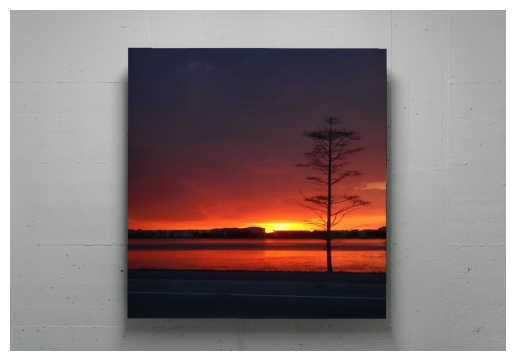

In [11]:
# open image to warp
fromim = np.array(cv2.imread('data/sunset_tree.jpg'))
fromim = cv2.flip(fromim, -1)
to_img = np.array(cv2.imread('data/rect.jpg'))

x = np.array([0, fromim.shape[1], 0, fromim.shape[1]])
y = np.array([0, 0, fromim.shape[0], fromim.shape[0]])

# triangulate
tri = triangulate_points(np.stack((x, y), axis=1)).simplices

hsv = cv2.cvtColor(to_img, cv2.COLOR_BGR2HSV)
bin_image = cv2.inRange(hsv, np.array((0, 0, 0)), np.array((255, 255, 60)))

# find contours in the binary image
contours, hierarchy = cv2.findContours(bin_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for contour in contours:
    rect = cv2.minAreaRect(contour)

    box_points = cv2.boxPoints(rect)
    box_points = np.array([box_points[0], box_points[3], box_points[1], box_points[2]])

    area = int(rect[1][0] * rect[1][1])

    if area > 500:
        # convert points to hom. coordinates
        fp = np.vstack((y, x, np.ones((1, len(x)))))
        box_points = np.vstack((box_points[:,1], box_points[:,0], np.ones((1, len(box_points)))))
        # warp triangles
        to_img = pw_affine(fromim.copy(), to_img, fp, box_points, tri)

plt.axis('off')
plt.imshow(cv2.cvtColor(to_img, cv2.COLOR_BGR2RGB))